# Análisis de Componentes Principales

In [1]:
#Lectura de las librerías

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabasz_score
from collections import Counter 

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Instalación de paquetes necesarios para abordar el problema. 

!pip install yellowbrick


In [3]:
#Carga de la información

df_train_PCA = pd.read_csv('train_clean.csv', na_values=".", sep=",")
print(df_train_PCA.shape)
df_train_PCA.head(5)

(891, 10)


,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


In [4]:
df_train_PCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_male    891 non-null    int64  
 6   Embarked_Q  891 non-null    int64  
 7   Embarked_S  891 non-null    int64  
 8   Pclass_2    891 non-null    int64  
 9   Pclass_3    891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


Teniendo en cuenta la información con la que se estimará el modelo, el siguente paso es **normalizar** los datos asociados a las variables explicativas. Es importante mencionar que el Análisis de Componentes Principales es un algoritmo que se enfoca en el cálculo de distancias entre puntos, por tanto es sensible a las diferentes escalas en las que se puedan encontrar las variables. Para esta oportunidad, se llevará a cabo el proceso para las variables Age y Fare, no es necesario normalizar las variables que ya previamente se les ha realizado alguna transformación para convertirlas en variables Dummie.  

In [5]:
# Se divide el dataset entre la variable objetivo y las características explicativas

X = df_train_PCA.drop(columns='Survived')
y = df_train_PCA['Survived']

#Identificamos las variables numéricas para proceder con la normalización

numeric_columns = ['Age', 'Fare']

#Normalización de las columnas numéricas

scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Construcción del dataset con las características normalizadas 

df_train_PCA_Norm = pd.DataFrame(X, columns=X.columns)

print(df_train_PCA_Norm)

          Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S  \
0   -0.565736      1      0 -0.502445         1           0           1   
1    0.663861      1      0  0.786845         0           0           0   
2   -0.258337      0      0 -0.488854         0           0           1   
3    0.433312      1      0  0.420730         0           0           1   
4    0.433312      0      0 -0.486337         1           0           1   
..        ...    ...    ...       ...       ...         ...         ...   
886 -0.181487      0      0 -0.386671         1           0           1   
887 -0.796286      0      0 -0.044381         0           0           1   
888 -0.104637      1      2 -0.176263         0           0           1   
889 -0.258337      0      0 -0.044381         1           0           0   
890  0.202762      0      0 -0.492378         1           1           0   

     Pclass_2  Pclass_3  
0           0         1  
1           0         0  
2           0        

In [6]:
df_train_PCA_Norm.head(5)

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,-0.565736,1,0,-0.502445,1,0,1,0,1
1,0.663861,1,0,0.786845,0,0,0,0,0
2,-0.258337,0,0,-0.488854,0,0,1,0,1
3,0.433312,1,0,0.420730,0,0,1,0,0
4,0.433312,0,0,-0.486337,1,0,1,0,1


Teniendo la información normalizada, se procederá a ajustar el Análisis de Componentes Principales. En el primer paso, se crea una instancia del mismo para poder identificar tantos componentes principales como número de variables explicativas tenemos en nuestro Dataset. 

In [7]:
#Ajuste del modelo PCA

pca = PCA()

'''En esta línea ajustamos el modelo a los datos estandarizados, además, se
proyectan los datos originales en el espacio de los componentes''' 

df_proyected = pca.fit_transform(df_train_PCA_Norm)

Una vez ajustado el modelo de Componentes Principales, procedemos a identificar los pesos que cada una de las variables explicativas aporta a los componentes principales estimados.

In [8]:
loadings = pca.components_

#Para una mejor visualización, creamos un dataframe para revisar los pesos

df_loadings = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=X.columns)

In [9]:
df_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Age,-0.384482,0.589454,-0.688359,0.095519,0.121395,0.028471,-0.037557,0.046646,0.051197
SibSp,0.771284,-0.023496,-0.512362,-0.365554,-0.061488,0.061530,0.021967,-0.019333,0.001213
Parch,0.410259,0.084183,-0.031884,0.879920,0.110775,-0.100455,0.160255,-0.019738,-0.029863
Fare,0.281731,0.753563,0.491872,-0.197996,0.097681,-0.152600,-0.060126,0.171986,0.074879
Sex_male,-0.088912,-0.062217,-0.080137,-0.167489,0.078568,-0.721145,0.652762,0.013681,-0.035226
Embarked_Q,-0.011801,-0.032809,0.000439,-0.033260,0.198921,0.271961,0.213940,0.620005,-0.673772
Embarked_S,0.009422,-0.055353,-0.102944,0.082878,-0.365169,-0.571345,-0.604400,0.241097,-0.310112
Pclass_2,-0.025521,-0.002539,-0.020046,0.087047,-0.616402,0.131797,0.249213,0.562514,0.464233
Pclass_3,0.028715,-0.262737,-0.057185,-0.013444,0.632951,-0.155584,-0.263694,0.456440,0.473274


**Análisis**

* En el componente principal número 1, se identifica una carga importante de la variable "SibSp" (0.77), esto quiere decir que la cantidad de hermanos/conyugues que se encuentran en el barco está fuertemente relacionada con la varianza explicada por el primer componente.

* La característica más relevante en PC2 es "Age", al evidenciarse una carga positiva de 0.58, es decir que, la edad está estrechamente asociada con la varianza explicada por el componente en mención. Por su parte, en el PC3 esta misma característica exhibe una asociación fuerte y negativa entre la edad y el componente mencionado.

* Finalmente, se resalta que en el PC4 la carga más relevante está explicada por la variable "Parch" (0.88). Este resultado indica que la presencia o asuencia de padres/hijos dentro del barco puede influir en la forma en que se agrupan los pasajeros en términos de otras características presentes en el conjunto de datos.

Una vez teniendo la información asociada a las cargas con las cuales contribuye cada variable a cada componente principal, el siguiente paso es identicar el número de componentes necesarios para explicar el 80% de la variabilidad de la representación original de los datos. 

In [10]:
#Identificamos la varianza explicada por cada componente

explain_variance = pca.explained_variance_ratio_

In [11]:
# Se lleva a cabo el calculo de la varianza explicada acumulada

explain_variance_cumm = np.cumsum(explain_variance)

In [12]:
import numpy as np

# Identificar la varianza explicada acumulada
explain_variance_cumm = np.cumsum(explain_variance)

# Crear un DataFrame para almacenar la varianza explicada acumulada de cada componente principal
variance_df = pd.DataFrame({'Componente': [f'PC{i+1}' for i in range(len(explain_variance_cumm))],
                            'Varianza Explicada Acumulada': explain_variance_cumm})

# Encontrar el índice donde la varianza explicada acumulada alcanza o supera el 80%
indice_80_percent = np.argmax(explain_variance_cumm >= 0.8) + 1  # Sumar 1 para la numeración de los componentes

# Imprimir los resultados

print(variance_df)

# Imprimir donde se acumula el 80% de la varianza explicada
print("\nEl número de componentes principales necesarios para conservar al menos el 80% de la representación original es: ", indice_80_percent)


  Componente  Varianza Explicada Acumulada
0        PC1                      0.337397
1        PC2                      0.583220
2        PC3                      0.734907
3        PC4                      0.831597
4        PC5                      0.896687
5        PC6                      0.945514
6        PC7                      0.979820
7        PC8                      0.991678
8        PC9                      1.000000

El número de componentes principales necesarios para conservar al menos el 80% de la representación original es:  4


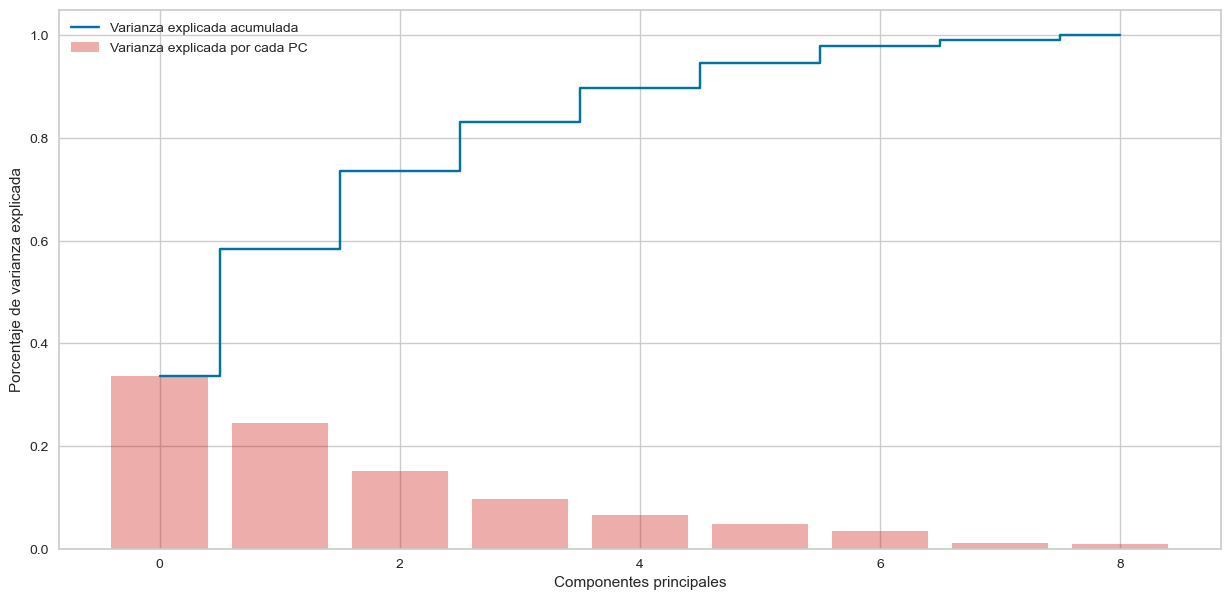

In [13]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(explain_variance)), explain_variance, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'r')
plt.step(range(len(explain_variance_cumm)), explain_variance_cumm, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

# Clustering - Método K Means

In [14]:
#Previamente encontramos que el número de componentes que funciona para explicar el 80% de la variabilidad es 4

# Se convierte el dataframe df_proyected a numpy array

if isinstance(df_proyected, pd.DataFrame):
    df_proyected = df_proyected.to_numpy()

# Se seleccionan los primeros 4 componentes principales

df_pca = df_proyected[:, :4] 
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(4)])
print(df_pca.head())


        PC1       PC2       PC3       PC4
0  0.277744 -0.907169 -0.168053 -0.522068
1  0.218993  1.169490 -0.140027 -0.561837
2 -0.518989 -0.630017  0.219529  0.037646
3  0.213911  0.702348 -0.264351 -0.428492
4 -0.873119 -0.282642 -0.335472 -0.064275


Una vez teniendo identificada la información de los componentes que explican el 80% de la variabilidad de la representación original, aplicaremos diferentes métodos para encontrar cuál es el mejor K para el método de K-Means. A través de los mismos, se podrá identificar la cantidad de grupos óptima en el que dividiremos los datos.

### Método del Codo

Se enfoca en la idea de que el valor óptimo de k se encuentra en el punto en el que la suma de distancias cuadradas de cada punto a su respectivo centroide se estabiliza o donde se evidencia una disminución más lenta de dicha métrica.

In [15]:
wcss = []
clusters_evaluar = 10
for i in range(1, clusters_evaluar):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(df_pca)
    wcss.append(kmeans_pca.inertia_)
clusters_optimos = KneeLocator([i for i in range(1, clusters_evaluar)], wcss, curve='convex', direction='decreasing').knee
print("Número Optimo de Clusters", clusters_optimos)

Número Optimo de Clusters 4


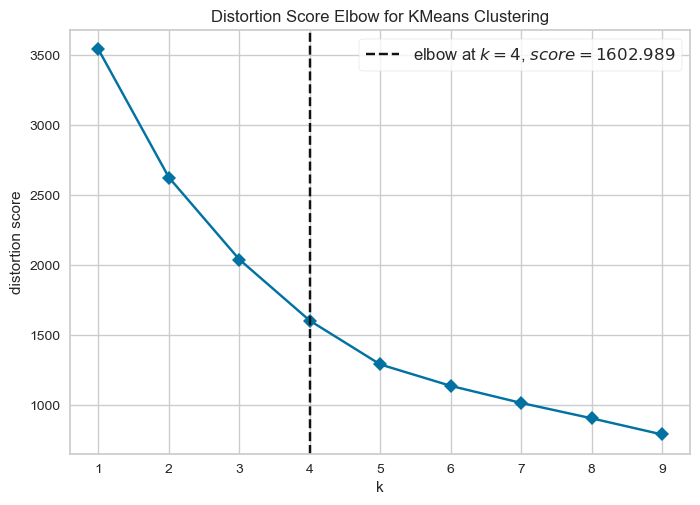

In [16]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,10), timings=False)
visualizer.fit(df_pca)
visualizer.show()
cluster_optimo = visualizer.elbow_value_


**Análisis**

En el gráfico anterior se evidencia la puntuación o score de distorsión en el eje Y, que representa la suma de las distancias al cuadrado de cada punto en el dataset a su centroide más cercano. Un valor más bajo en esta métrica da indicios de que los puntos están más cerca de sus centroides.

En este contexto, se evidencia que a medida que el número de clusters (k) aumenta de 1 a 4, el score mencionado disminuye rápidamente, indicando una mejora significativa en la agrupación. Sin embargo, después de k=4, la disminución en el score se hace más lenta. Esto sugiere que k=4 es el número óptimo de clusters para este conjunto de datos.

Incrementar el número de clusters despúes de este k óptimo, no resultaría en una mejora sustancial de la puntuación de distorsión, pues el cálculo de clusters adicionales no necesariamente capturarían estructuras signtificativas dentro del conjunto de datos objetivo, incluso, se podría correr el riesgo de caer en overfitting en donde se presentaría un problema de generalización a nuevos datos.





### Método de la Silueta

Este método se utiliza para evaluar que tan buenos son los agrupamientos que se están realizando con el conjunto de datos en cuestión. Para cada uno de los puntos se calcula la distancia promedio respecto al resto de puntos en el mismo cluster, además, la distancia promedio al cluster más cercano que sea distinto al que pertenece dicho punto. La silueta promedio de todos los puntos exhibe una medida de la calidad de los agrupamientos.

Para n_clusters = 2 El silhouette_score promedio es : 0.5223741060824285
Para n_clusters = 3 El silhouette_score promedio es : 0.41888387552756595
Para n_clusters = 4 El silhouette_score promedio es : 0.40768239450142235
Para n_clusters = 5 El silhouette_score promedio es : 0.41740597180968547
Para n_clusters = 6 El silhouette_score promedio es : 0.4234793642801772
Para n_clusters = 7 El silhouette_score promedio es : 0.4242394214276467
Para n_clusters = 8 El silhouette_score promedio es : 0.43395890213027544
Para n_clusters = 9 El silhouette_score promedio es : 0.418212769519063


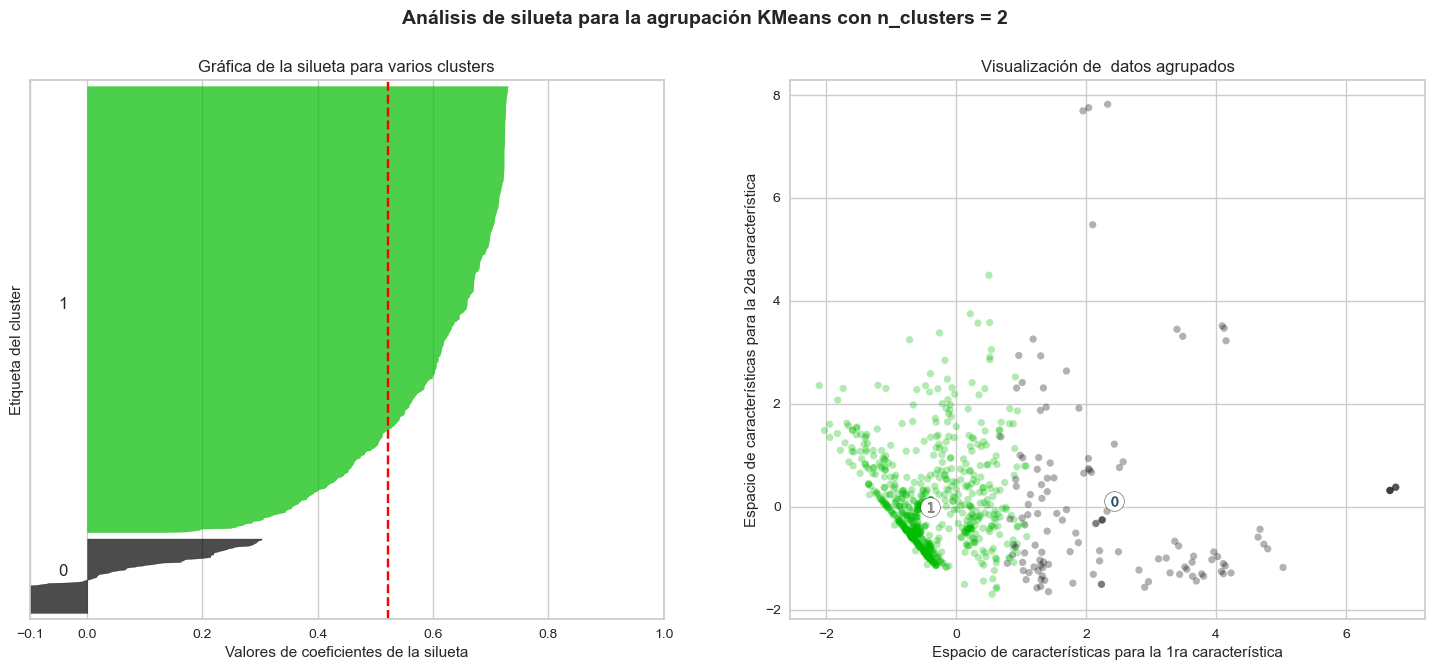

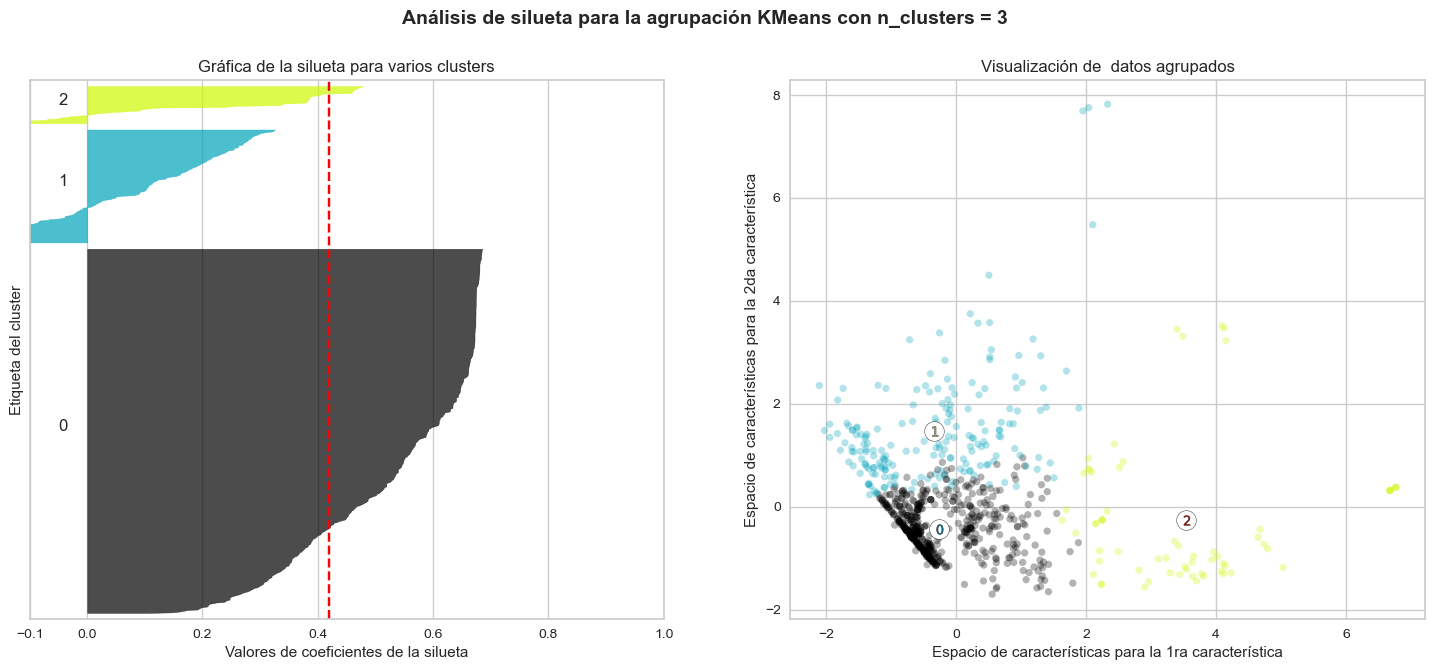

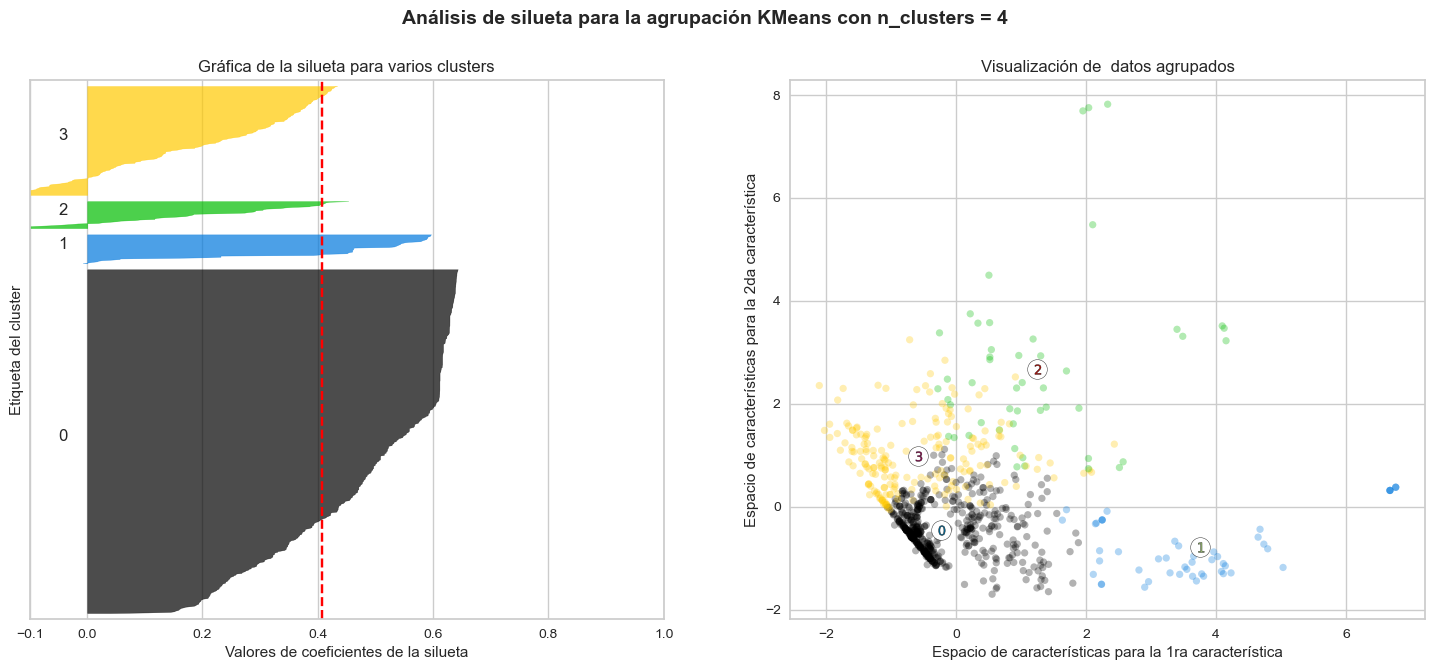

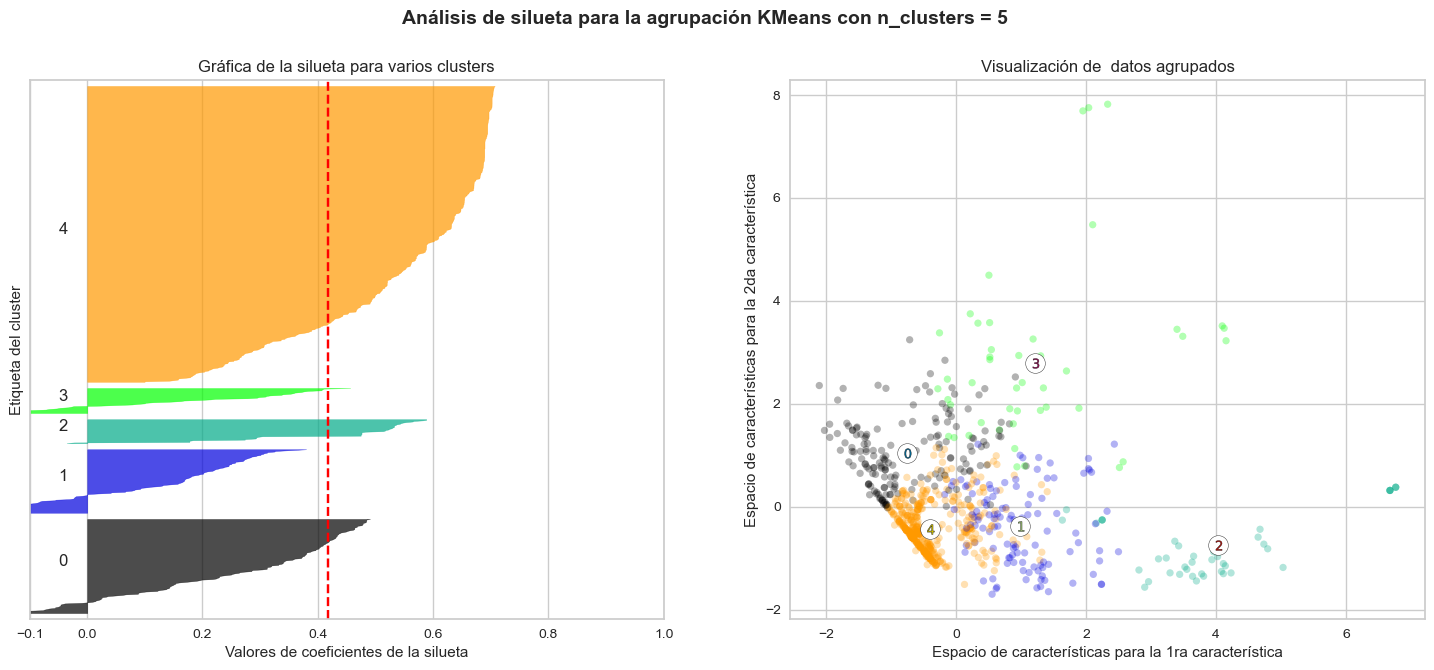

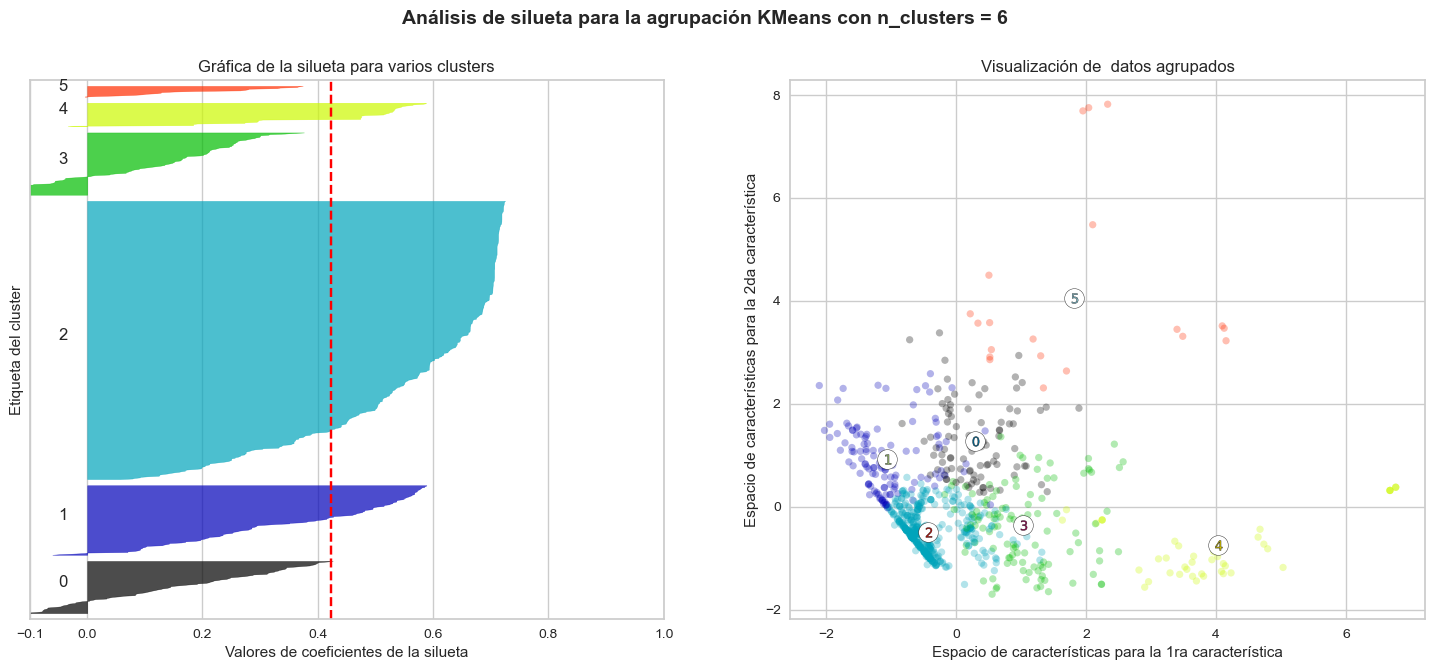

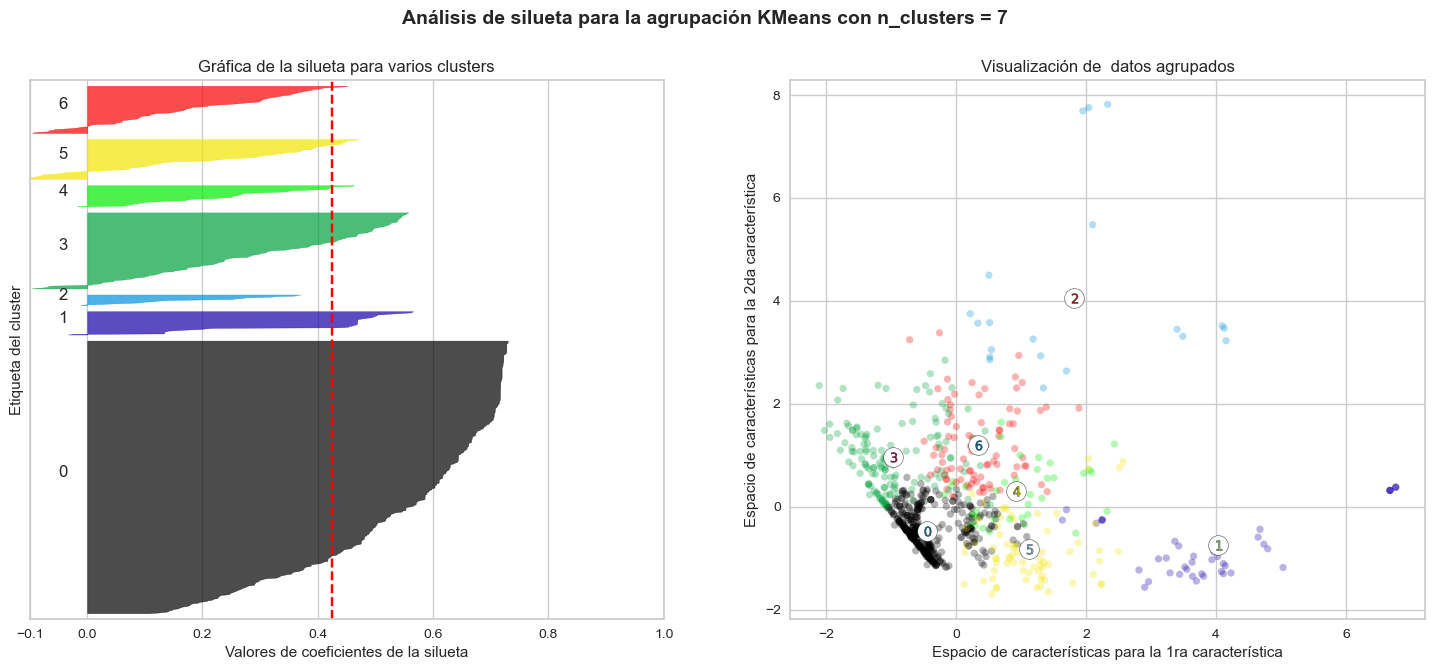

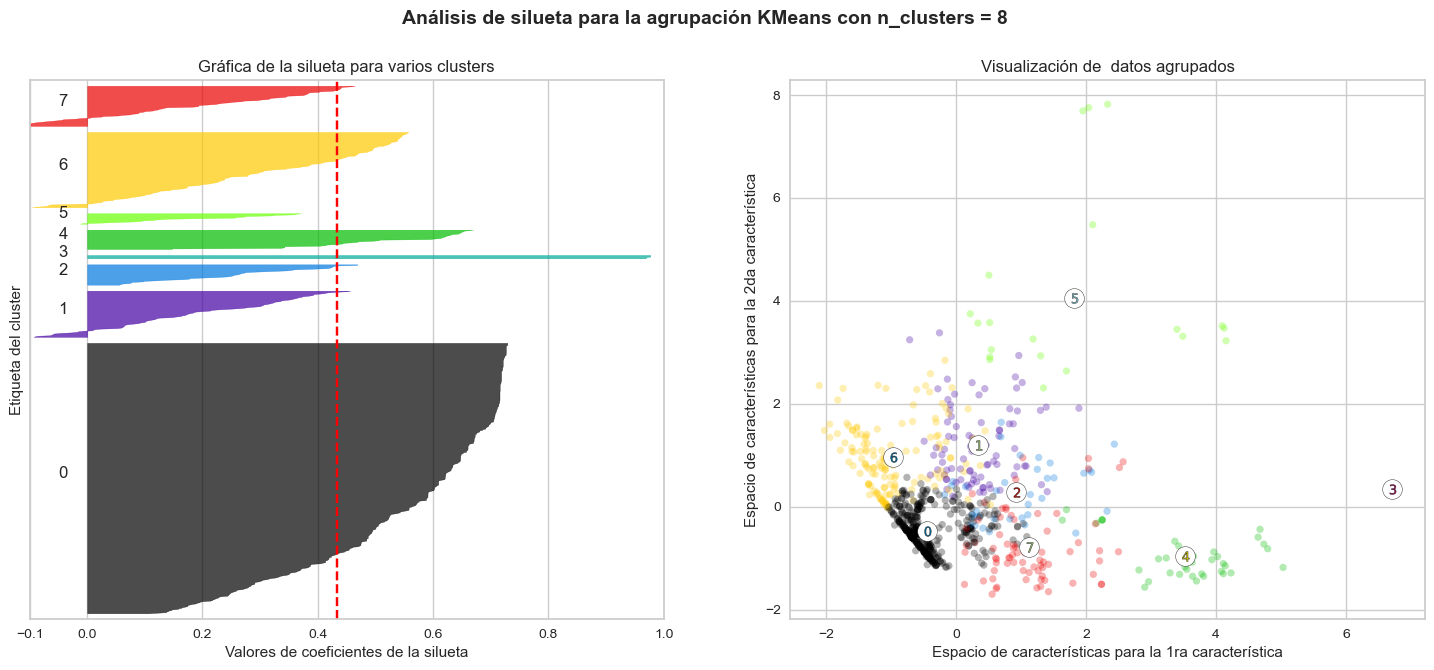

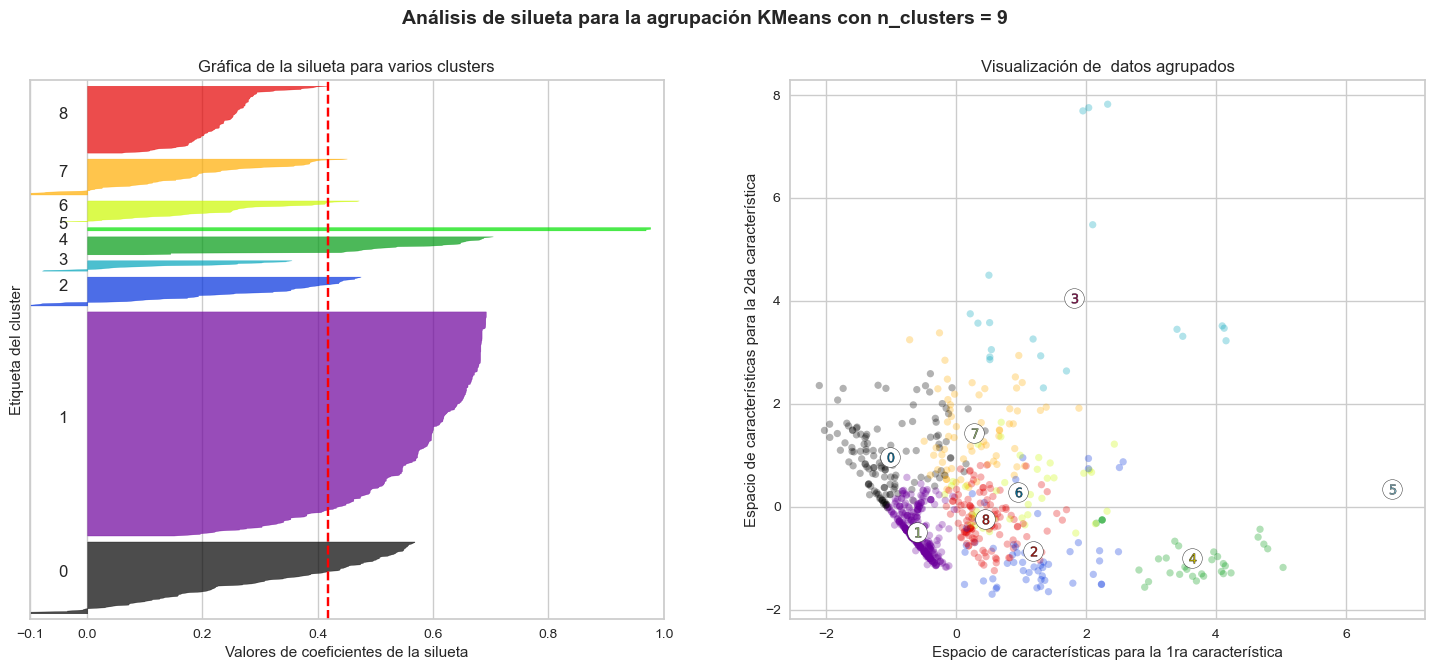

In [17]:
range_n_clusters = range(2, 10)  # Número de clusters que se probarán en el método

for n_clusters in range_n_clusters:
    # Crear una subplot con 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Configurar los límites de la gráfica de la silueta
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    # Inicializar el modelo KMeans con el número de clusters actual
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_pca)

    # Calcular la puntuación de silueta media para todos los samples
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Calcular los valores de la silueta para cada muestra
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Agregar los valores de silueta para cada cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar los clusters en la gráfica
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular el nuevo 'y_lower' para el siguiente plot
        y_lower = y_upper + 10  

    ax1.set_title("Gráfica de la silueta para varios clusters")
    ax1.set_xlabel("Valores de coeficientes de la silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # Línea vertical para el silhouette_score promedio de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Visualización de los clusters formados
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_pca['PC1'], df_pca['PC2'], marker='.', s=110, lw=0, alpha=0.3,
                c=colors, edgecolor='k')

    # Etiquetar los centroides de los clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualización de  datos agrupados")
    ax2.set_xlabel("Espacio de características para la 1ra característica")
    ax2.set_ylabel("Espacio de características para la 2da característica")

    plt.suptitle(("Análisis de silueta para la agrupación KMeans "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


**Análisis**

Aunque el método de la silueta sugiere que se debe seleccionar el número óptimo de clusters basado en el score promedio más alto, en este caso, no es tan sencillo seguir esta recomendación.

Para un número de cluster igual a 2, el valor promedio del score de la silueta es de 0.52. Sin embargo, al examinar el gráfico, se observa que no todos los puntos agrupados en uno de los clusters están por encima de este promedio (indicado por la línea roja). Aunque es importante tener un score alto, también es crucial que no haya una cantidad significativa de puntos por debajo de dicho umbral, ya que esto puede indicar que algunos puntos están mal asignados.

Por lo tanto, es importante tener en cuenta el valor del score promedio como la distribución de los scores individuales dentro de los clusters para asegurar una agrupación efectiva.

### Método de Calinski Harabasz

El método de Calinski-Harabasz ofrece otra forma de evaluar la calidad de los agrupamientos en un conjunto de datos. A diferencia del método de la silueta, que se enfoca en la coherencia y separación de los clusters a nivel de punto, Calinski-Harabasz considera tanto la dispersión entre clusters como la cohesión dentro de los clusters. Para este método se busca el K que maximice la separación entre cluster, con cluster lo más compactos posibles.

In [18]:
CHs = []
for i in range(2,10) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_pca)
    CH = calinski_harabasz_score(df_pca, km.labels_) 
    CHs.append(CH)

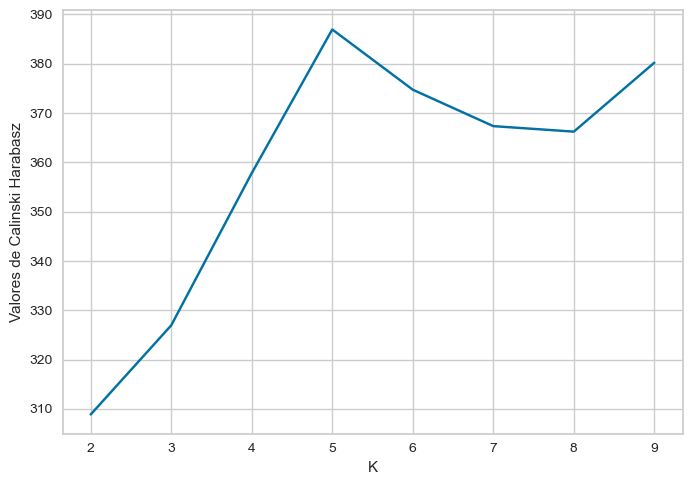

In [19]:
plt.plot(range(2, 10), CHs)
plt.ylabel("Valores de Calinski Harabasz")
plt.xlabel("K")
plt.show()

**Análisis**

El gráfico anterior muestra un pico pronunciado en k=5 según el método de Calinski-Harabasz, que mide la dispersión entre los clusters en comparación con la dispersión dentro de cada cluster. Este pico indica que 5 es el número óptimo de clusters para usar en el método de k-means. La razón es que, después de este punto, el índice disminuye significativamente, lo que sugiere que tener más de 5 clusters puede no ser adecuado y podría llevar a una peor agrupación.

**¿Qué metodo utilizar?**

Como se observó en las últimas aplicaciones, cada uno de los métodos sugiere un número de clusters diferentes. Sin embargo, es importante no dejar de lado que estos métodos son heurísticas que apoyan en la decisión de cuál es el mejor agrupamiento, por tanto, es responsabilidad del investigador seleccionar aquel que refleja la mejor aplicación o solución al problema que se esté analizando. 

Para este en objetivo en particular, en el que se busca llevar a cabo un proceso de caracterización de pasajeros se optará por guiar la selección del número óptimo de clusters a partir del Método del Codo. Esta decisión se basa en varios puntos. 

* Seleccionar 4 clusters proporciona al análisis un equilibrio óptimo entre la precisión del modelo y la complejidad de mismo. Por su parte, el método de la silueta que aunque perimitió analizar la cohesión y separación de la agrupaciones, sugiere una simplificación extrema que quizá no capture de manera adecuada la estructura de los datos a analizar (2 clusters). 

Por su parte, el método de calinski sugiere 5 clusters que pueden resultar en una mayor complejidad del modelo que no necesariamente está representada en una mejora significativa de la agrupación (veíamos a través del método del codo que después de 4 clusters la suma de las distancias al cuadrado de cada punto a su centroide más cercano disminuye de forma gradual o no importante).

* La selección de 4 clusters permite una interpretación más intuitiva (podemos afirmar esto, debido a que el método ya nos sugirió dicha cantidad de agrupaciones, no es una argumentación sin fundamentos), además, permite clasificar sin una segmentación excesiva de los datos. 

En conclusión, seguir la recomendación del método del codo y optar por 4 clusters ofrece un equilibrio ideal entre precisión, simplicidad y eficiencia, lo que puede aportar a la robustez del modelo y  asu fácil interpretación, buscando evitar tanto el sobreajuste como el subajuste de los datos.

### Método de K-Means con K=4

A partir de la elección del K-Óptimo que se generó en el paso anterior, se ejecutará un K-Means que corresponde a un algoritmo de aprendizaje no supervisado que agrupará los datos en 4 conglomerados. Esto servirá para identificar las características de los pasajeros que se tienen en el conjunto de datos.

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans.fit(df_pca)
clusters = kmeans.labels_

In [21]:
df_pca

,PC1,PC2,PC3,PC4
0,0.277744,-0.907169,-0.168053,-0.522068
1,0.218993,1.169490,-0.140027,-0.561837
2,-0.518989,-0.630017,0.219529,0.037646
3,0.213911,0.702348,-0.264351,-0.428492
4,-0.873119,-0.282642,-0.335472,-0.064275
...,...,...,...,...
886,-0.662896,-0.309735,0.173892,-0.042243
887,-0.215651,-0.349438,0.865640,-0.088298
888,1.101785,-0.158991,-0.308646,1.384722
889,-0.520816,-0.039205,0.518145,-0.287281


In [22]:
from collections import Counter

df_pca['Cluster']= clusters
counter=Counter(clusters)
print(counter)

Counter({0: 607, 1: 185, 3: 51, 2: 48})


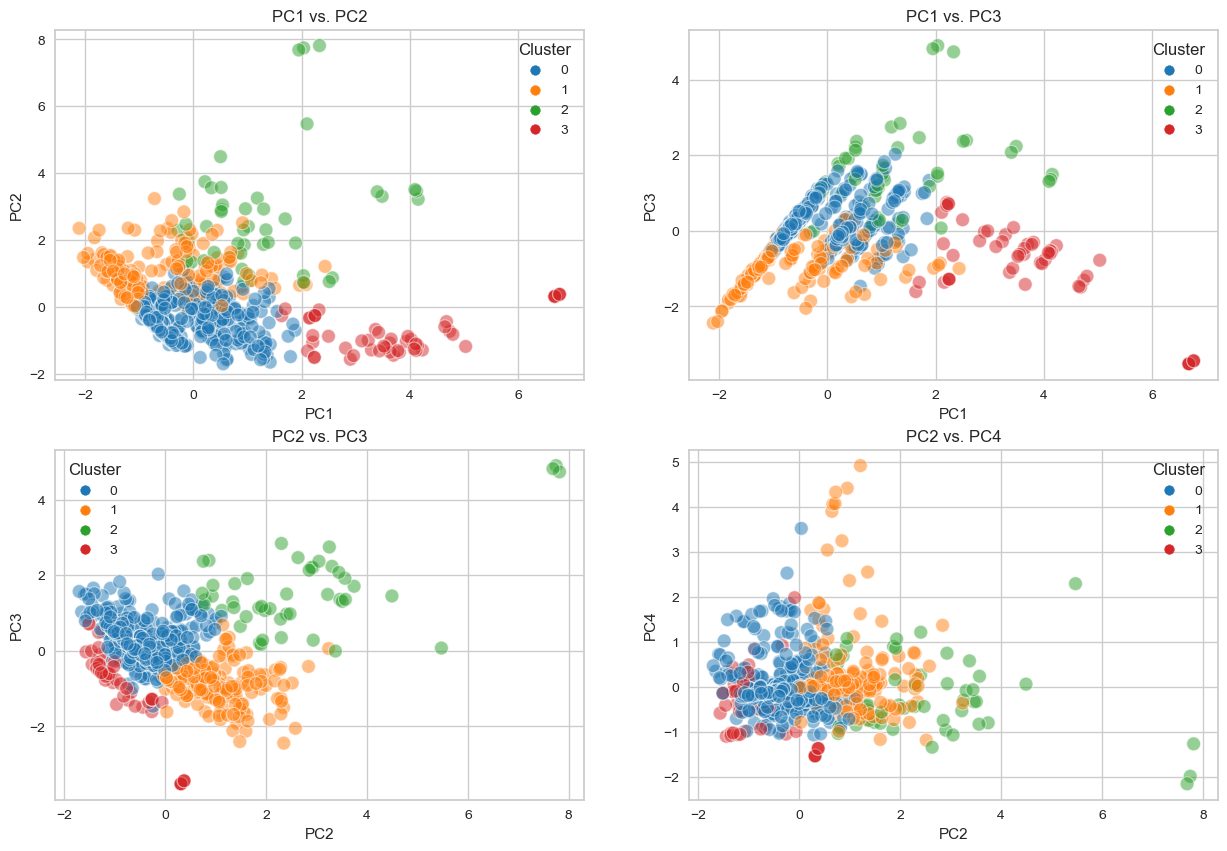

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=df_pca, ax=ax, palette="tab10", s=100, alpha=0.5)
plt.title("PC1 vs. PC2")

ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="PC1", y="PC3", hue="Cluster", data=df_pca, ax=ax, palette="tab10", s=100, alpha=0.5)
plt.title("PC1 vs. PC3")

ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="PC2", y="PC3", hue="Cluster", data=df_pca, ax=ax, palette="tab10", s=100, alpha=0.5)
plt.title("PC2 vs. PC3")

ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="PC2", y="PC4", hue="Cluster", data=df_pca, ax=ax, palette="tab10", s=100, alpha=0.5)
plt.title("PC2 vs. PC4")

plt.show()


Ahora bien, con el objetivo de caracterizar los conglomerados con respecto a las variables originales, se cruzará la información del dataframe inicial con los cluster identificados.

In [24]:
# Cruce de información

df_train_PCA['Cluster']=df_pca['Cluster']
df_train_PCA

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Cluster
0,0,22.0,1,0,7.2500,1,0,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,0,0,1
2,1,26.0,0,0,7.9250,0,0,1,0,1,0
3,1,35.0,1,0,53.1000,0,0,1,0,0,1
4,0,35.0,0,0,8.0500,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,1,0,1,1,0,0
887,1,19.0,0,0,30.0000,0,0,1,0,0,0
888,0,28.0,1,2,23.4500,0,0,1,0,1,0
889,1,26.0,0,0,30.0000,1,0,0,0,0,0


A continuación, se calculan las estadísticas descriptivas asociadas a cada cluster, enfoncandose en las características de los pasajeros que pertenecen a cada una de la agrupaciones.

In [25]:
# Filtrar las estadísticas descriptivas por cluster
clusters = df_train_PCA['Cluster'].unique()
statistics_by_cluster = {}

for cluster in clusters:
    cluster_data = df_train_PCA[df_train_PCA['Cluster'] == cluster]
    statistics_by_cluster[cluster] = cluster_data.describe(include='all')

# Imprimir las estadísticas descriptivas para cada cluster
for cluster, stats in statistics_by_cluster.items():
    print(f"Cluster {cluster} Statistics:\n", stats, "\n")

Cluster 0 Statistics:
          Survived         Age       SibSp       Parch        Fare    Sex_male  \
count  607.000000  607.000000  607.000000  607.000000  607.000000  607.000000   
mean     0.365733   25.068781    0.253707    0.212521   17.803026    0.688633   
std      0.482032    7.302587    0.482241    0.550405   17.551060    0.463435   
min      0.000000    0.420000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   21.000000    0.000000    0.000000    7.854200    0.000000   
50%      0.000000   28.000000    0.000000    0.000000   10.170800    1.000000   
75%      1.000000   28.000000    0.000000    0.000000   21.000000    1.000000   
max      1.000000   40.500000    2.000000    4.000000   93.500000    1.000000   

       Embarked_Q  Embarked_S    Pclass_2    Pclass_3  Cluster  
count  607.000000  607.000000  607.000000  607.000000    607.0  
mean     0.108731    0.714992    0.215815    0.655684      0.0  
std      0.311559    0.451791    0.411726    0.47553

Ahora, se propone un análisis gráfico para comparar algunas características de los pasajeros que pertenecen a cada uno de los clusters:

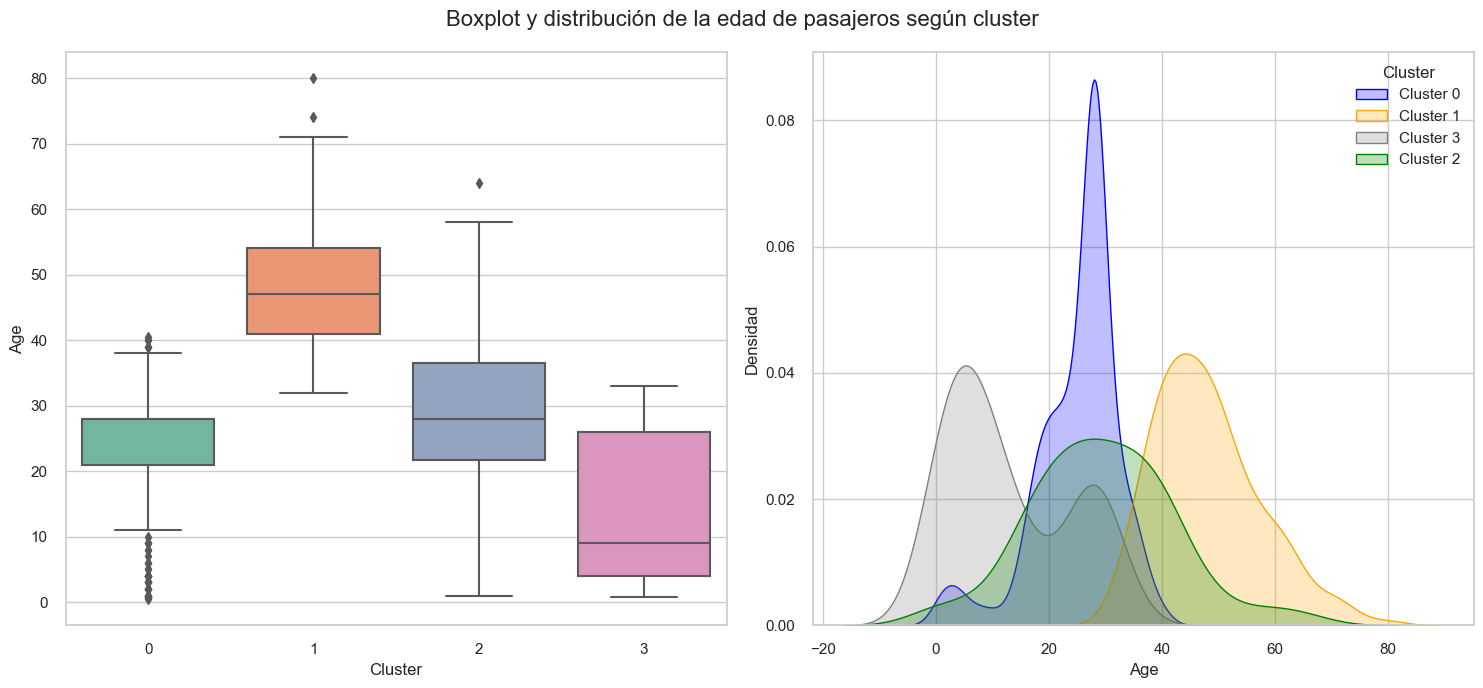

In [26]:
# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Crear la figura y los subplots

plt.figure(figsize=(15, 7))
plt.suptitle("Boxplot y distribución de la edad de pasajeros según cluster", fontsize=16)

# Diagrama de caja

plt.subplot(1, 2, 1)
ax = sns.boxplot(x=df_train_PCA['Cluster'], y=df_train_PCA['Age'], palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Age")

# Distribuciones de densidad

plt.subplot(1, 2, 2)
colors = ['blue', 'orange', 'green', 'grey']
for cluster in df_train_PCA['Cluster'].unique():
    sns.kdeplot(df_train_PCA[df_train_PCA['Cluster'] == cluster]['Age'], shade=True, color=colors[cluster], label=f'Cluster {cluster}')

plt.xlabel("Age")
plt.ylabel("Densidad")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


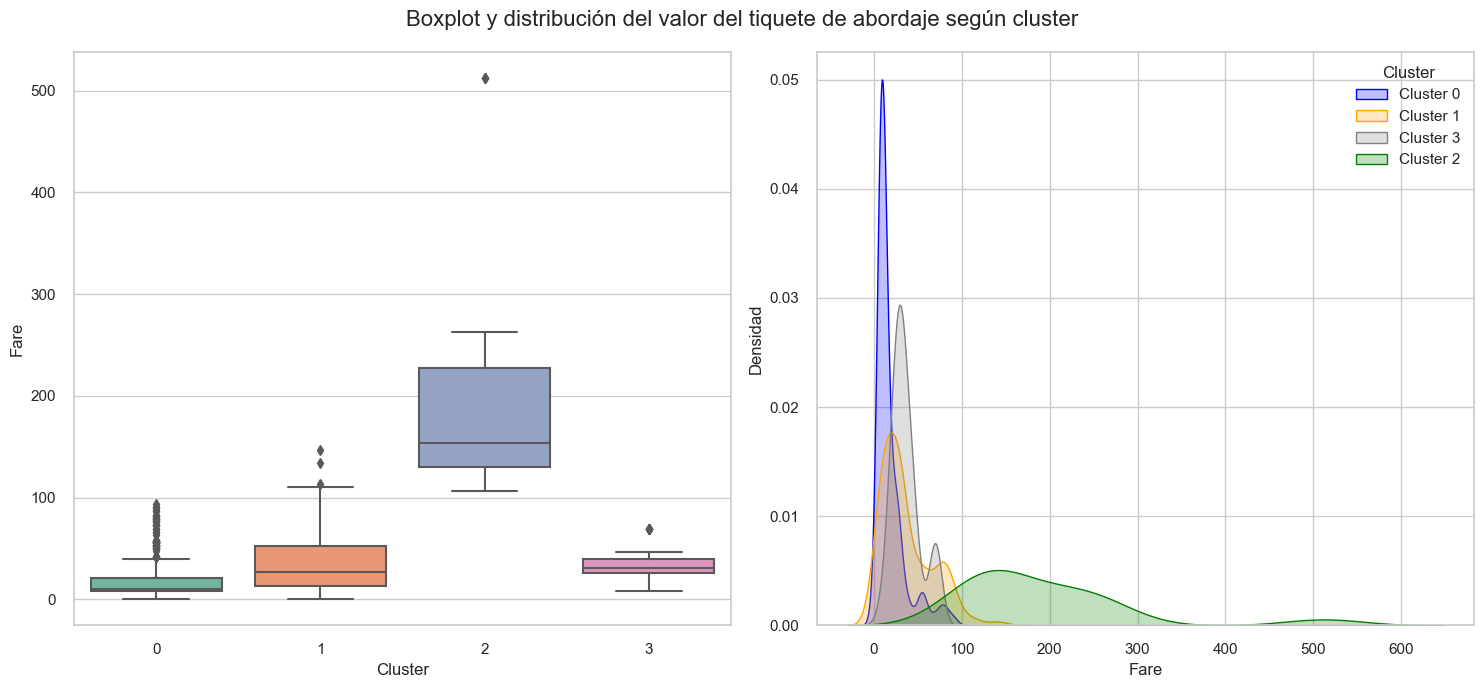

In [27]:
# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Crear la figura y los subplots

plt.figure(figsize=(15, 7))
plt.suptitle("Boxplot y distribución del valor del tiquete de abordaje según cluster", fontsize=16)

# Diagrama de caja

plt.subplot(1, 2, 1)
ax = sns.boxplot(x=df_train_PCA['Cluster'], y=df_train_PCA['Fare'], palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Fare")

# Distribuciones de densidad

plt.subplot(1, 2, 2)
colors = ['blue', 'orange', 'green', 'grey']
for cluster in df_train_PCA['Cluster'].unique():
    sns.kdeplot(df_train_PCA[df_train_PCA['Cluster'] == cluster]['Fare'], shade=True, color=colors[cluster], label=f'Cluster {cluster}')

plt.xlabel("Fare")
plt.ylabel("Densidad")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

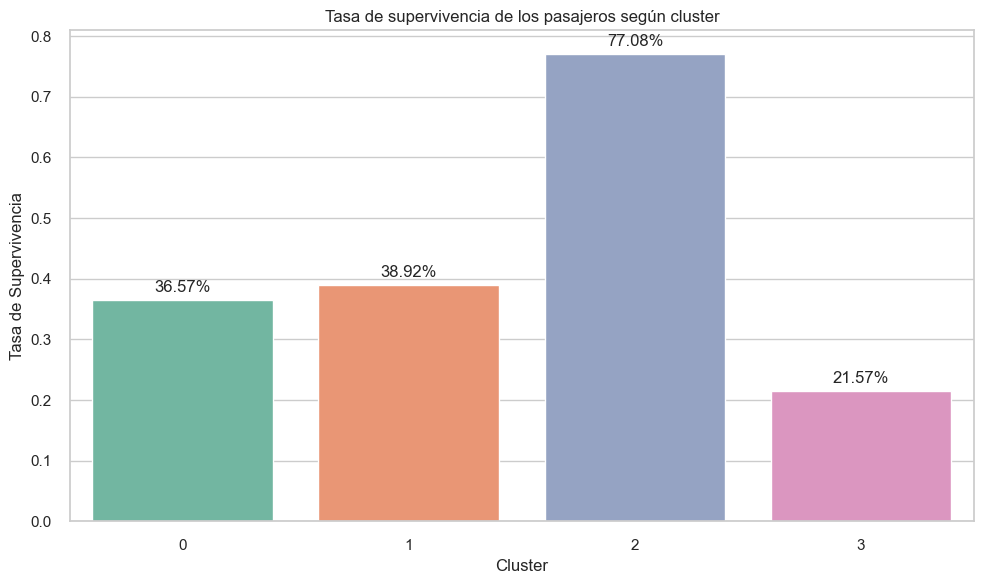

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la tasa de supervivencia por cluster
survival_rates = df_train_PCA.groupby('Cluster')['Survived'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cluster', y='Survived', data=survival_rates, palette="Set2")

# Añadir etiquetas y título
plt.xlabel("Cluster")
plt.ylabel("Tasa de Supervivencia")
plt.title("Tasa de supervivencia de los pasajeros según cluster")

# Mostrar el porcentaje en la parte superior de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.tight_layout()
plt.show()


**Conclusiones**

Teniendo en cuenta la información proporcionada a través del algortimo de K-Means para la caracterización de los pasajeros, se encontraron las siguientes características por agrupación:

**Cluster 0 / 607 pasajeros**

- Los individuos de este cluster tienen una edad promedio de 25 años, además se caracterizan por ser pasajeros que no tienen hermanos o parejas dentro de la embarcación. Un dato importante a tener en cuenta, es que la mayor proporción de los pasajeros en este cluster son hombres (68,8%). Finalmente, el 71,5% de los pasajeros de este cluster embarcó en el puerto S.

**Cluster 1 / 185 pasajeros**

- En este cluster se encuentran pasajeros que en su mayoría viajan en primera clase, debido a que las variables PClass2 y PClass3 exhiben que el 26,5% y el 24,9% viajan en segunda y tercera clase, respectivamente. Adicionalmente, se encuentra en esta agrupación un grupo de pasajeros mayor frente al cluster 0, pues el promedio de la edad es de 48 años. Así como se observa en el cluster anterior, la mayoría de los pasajeros en esta agrupación son hombres (64,3%)


**Cluster 2 / 48 pasajeros**

- Los pasajeros asociados agrupados a este agrupamiento exhiben la proporción más alta de individuos que sobreviven, asociada al 77,0%. Estos pasajeros tiene una edad promedio de 29 años y la mayoría son mujeres (promedio del género femenino es de 68,8%). También, un resultado importante de este cluster, es que todos los pasajeros pertenecen a primera clase. 

**Cluster 3 / 51 pasajeros**

- En este cluster la mayoría de los pasajeros son niños y jovenes, pues la edad promedio corresponde a 12,8 años. Adicionalmente, se encontró una paridad entre los géneros de este grupo, pues el 49,0% del mismo corresponde al género masculino. En este caso, se destaca que el 92,2% de los pasajeros de este conglomerado viajaban en tercera clase, es decir, dados los resultados de los últimos cluster, pareciera que la clase fue determinante en la sobrevivencia de los pasajeros, pues para este grupo solo el 21,6% sobrevivió. 




